In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/individual-seasonal-trend-residual-dataframes/df_residual.csv
/kaggle/input/individual-seasonal-trend-residual-dataframes/df_trend.csv
/kaggle/input/individual-seasonal-trend-residual-dataframes/df_seasonal.csv


In [2]:
!pip install feature-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.1/364.1 kB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 50.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.8.2 which is incompatible.
spaghe

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import random
#import shap
import optuna
import joblib
#!pip install openpyxl
from feature_engine.timeseries.forecasting import LagFeatures
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if y_true.ndim > 1:
        y_true = y_true.flatten()  # Flatten if y_true is 2-dimensional
    if y_pred.ndim > 1:
        y_pred = y_pred.flatten()  # Flatten if y_pred is 2-dimensional

    non_zero_mask = (y_true != 0) & (y_pred != 0)  # Exclude zero values from calculation
    y_true = y_true[non_zero_mask]
    y_pred = y_pred[non_zero_mask]

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if len(y_true) != 0 else np.nan

In [5]:
df = pd.read_csv('/kaggle/input/individual-seasonal-trend-residual-dataframes/df_trend.csv')
df

,Date_Time,Is_Holiday,Holiday_Type,OneHourSlot,Month,Year,Weekday,Trend
0,2019-01-01 00:00:00,0,0,1,1,2019,1,68.788995
1,2019-01-01 01:00:00,0,0,2,1,2019,1,68.779800
2,2019-01-01 02:00:00,0,0,3,1,2019,1,68.772500
3,2019-01-01 03:00:00,0,0,4,1,2019,1,68.766954
4,2019-01-01 04:00:00,0,0,5,1,2019,1,68.762759
...,...,...,...,...,...,...,...,...
46459,2024-04-19 19:00:00,0,0,20,4,2024,4,56.533830
46460,2024-04-19 20:00:00,0,0,21,4,2024,4,56.606303
46461,2024-04-19 21:00:00,0,0,22,4,2024,4,56.679462
46462,2024-04-19 22:00:00,0,0,23,4,2024,4,56.753581


In [6]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'], format='%Y-%m-%d %H:%M:%S')
#df.drop(columns='OneHourSlot',inplace=True)
#df['hour'] = df['Date_Time'].dt.hour
df

,Date_Time,Is_Holiday,Holiday_Type,OneHourSlot,Month,Year,Weekday,Trend
0,2019-01-01 00:00:00,0,0,1,1,2019,1,68.788995
1,2019-01-01 01:00:00,0,0,2,1,2019,1,68.779800
2,2019-01-01 02:00:00,0,0,3,1,2019,1,68.772500
3,2019-01-01 03:00:00,0,0,4,1,2019,1,68.766954
4,2019-01-01 04:00:00,0,0,5,1,2019,1,68.762759
...,...,...,...,...,...,...,...,...
46459,2024-04-19 19:00:00,0,0,20,4,2024,4,56.533830
46460,2024-04-19 20:00:00,0,0,21,4,2024,4,56.606303
46461,2024-04-19 21:00:00,0,0,22,4,2024,4,56.679462
46462,2024-04-19 22:00:00,0,0,23,4,2024,4,56.753581


In [7]:
df.drop(columns='OneHourSlot', inplace=True)

In [8]:
df.head(3)

,Date_Time,Is_Holiday,Holiday_Type,Month,Year,Weekday,Trend
0,2019-01-01 00:00:00,0,0,1,2019,1,68.788995
1,2019-01-01 01:00:00,0,0,1,2019,1,68.779800
2,2019-01-01 02:00:00,0,0,1,2019,1,68.772500


# filtering out the df from 1st Jan 2019 to 20th April 2024

In [9]:
# Define start and end dates
start_date = pd.Timestamp(2019, 1, 1)
end_date = pd.Timestamp(2024, 4, 20)

# Filter the DataFrame
df = df[(df['Date_Time'] >= start_date) & (df['Date_Time'] < end_date)]
df

,Date_Time,Is_Holiday,Holiday_Type,Month,Year,Weekday,Trend
0,2019-01-01 00:00:00,0,0,1,2019,1,68.788995
1,2019-01-01 01:00:00,0,0,1,2019,1,68.779800
2,2019-01-01 02:00:00,0,0,1,2019,1,68.772500
3,2019-01-01 03:00:00,0,0,1,2019,1,68.766954
4,2019-01-01 04:00:00,0,0,1,2019,1,68.762759
...,...,...,...,...,...,...,...
46459,2024-04-19 19:00:00,0,0,4,2024,4,56.533830
46460,2024-04-19 20:00:00,0,0,4,2024,4,56.606303
46461,2024-04-19 21:00:00,0,0,4,2024,4,56.679462
46462,2024-04-19 22:00:00,0,0,4,2024,4,56.753581


In [10]:
sp = 'Voltas_Gate_Thane_Station_West'

In [11]:
# Setting seeds for random number generators in different libraries ensures reproducibility of results.

random.seed(100)
np.random.seed(100)
tf.random.set_seed(100)

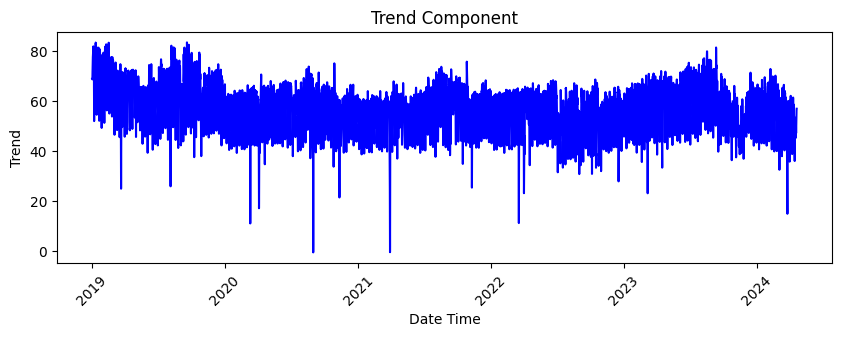

In [12]:
# Plotting the graph
plt.figure(figsize=(10, 3))  # Set the width and height of the figure
plt.plot(df['Date_Time'].to_numpy(), df['Trend'].to_numpy(), color='blue')
plt.title(f"Trend Component")
plt.xlabel('Date Time')  # X-axis label
plt.ylabel('Trend')  # Y-axis label
plt.tick_params('x', labelrotation=45)  # Rotate x-axis labels by 45 degrees
plt.show()


In [13]:
df['Trend'].to_numpy()

array([68.78899515, 68.77979965, 68.77250021, ..., 56.67946172,
       56.75358063, 56.82820605])

In [14]:
df.loc[df['Trend'] < 0, 'Trend'] = 0

In [15]:
df['Trend']

0        68.788995
1        68.779800
2        68.772500
3        68.766954
4        68.762759
           ...    
46459    56.533830
46460    56.606303
46461    56.679462
46462    56.753581
46463    56.828206
Name: Trend, Length: 46464, dtype: float64

In [16]:
df

,Date_Time,Is_Holiday,Holiday_Type,Month,Year,Weekday,Trend
0,2019-01-01 00:00:00,0,0,1,2019,1,68.788995
1,2019-01-01 01:00:00,0,0,1,2019,1,68.779800
2,2019-01-01 02:00:00,0,0,1,2019,1,68.772500
3,2019-01-01 03:00:00,0,0,1,2019,1,68.766954
4,2019-01-01 04:00:00,0,0,1,2019,1,68.762759
...,...,...,...,...,...,...,...
46459,2024-04-19 19:00:00,0,0,4,2024,4,56.533830
46460,2024-04-19 20:00:00,0,0,4,2024,4,56.606303
46461,2024-04-19 21:00:00,0,0,4,2024,4,56.679462
46462,2024-04-19 22:00:00,0,0,4,2024,4,56.753581


In [17]:
df.to_csv('input_file_1.csv', index=False)
print(df.head(3))

            Date_Time  Is_Holiday  Holiday_Type  Month  Year  Weekday  \
0 2019-01-01 00:00:00           0             0      1  2019        1   
1 2019-01-01 01:00:00           0             0      1  2019        1   
2 2019-01-01 02:00:00           0             0      1  2019        1   

       Trend  
0  68.788995  
1  68.779800  
2  68.772500  


In [18]:
# create lag features

lag_transformer = LagFeatures(variables=['Trend'], periods=[1,2,24,24*7,24*14,24*21,24*28])
df = lag_transformer.fit_transform(df)


In [19]:
df.head()

,Date_Time,Is_Holiday,Holiday_Type,Month,Year,Weekday,Trend,Trend_lag_1,Trend_lag_2,Trend_lag_24,Trend_lag_168,Trend_lag_336,Trend_lag_504,Trend_lag_672
0,2019-01-01 00:00:00,0,0,1,2019,1,68.788995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 01:00:00,0,0,1,2019,1,68.779800,68.788995,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 02:00:00,0,0,1,2019,1,68.772500,68.779800,68.788995,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 03:00:00,0,0,1,2019,1,68.766954,68.772500,68.779800,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 04:00:00,0,0,1,2019,1,68.762759,68.766954,68.772500,NaN,NaN,NaN,NaN,NaN


In [20]:
df.tail()

,Date_Time,Is_Holiday,Holiday_Type,Month,Year,Weekday,Trend,Trend_lag_1,Trend_lag_2,Trend_lag_24,Trend_lag_168,Trend_lag_336,Trend_lag_504,Trend_lag_672
46459,2024-04-19 19:00:00,0,0,4,2024,4,56.533830,56.460781,56.385058,49.808811,53.016968,54.026025,56.305112,55.388722
46460,2024-04-19 20:00:00,0,0,4,2024,4,56.606303,56.533830,56.460781,50.370035,52.498525,53.395408,56.720267,54.935932
46461,2024-04-19 21:00:00,0,0,4,2024,4,56.679462,56.606303,56.533830,50.933026,51.921324,52.676742,57.106281,54.425914
46462,2024-04-19 22:00:00,0,0,4,2024,4,56.753581,56.679462,56.606303,51.463233,51.308639,51.907232,57.417123,53.883858
46463,2024-04-19 23:00:00,0,0,4,2024,4,56.828206,56.753581,56.679462,51.937326,50.677318,51.121939,57.610725,53.347722


In [21]:
df.to_csv('input_file_2.csv', index=False)
print(df.head(3))

            Date_Time  Is_Holiday  Holiday_Type  Month  Year  Weekday  \
0 2019-01-01 00:00:00           0             0      1  2019        1   
1 2019-01-01 01:00:00           0             0      1  2019        1   
2 2019-01-01 02:00:00           0             0      1  2019        1   

       Trend  Trend_lag_1  Trend_lag_2  Trend_lag_24  Trend_lag_168  \
0  68.788995          NaN          NaN           NaN            NaN   
1  68.779800    68.788995          NaN           NaN            NaN   
2  68.772500    68.779800    68.788995           NaN            NaN   

   Trend_lag_336  Trend_lag_504  Trend_lag_672  
0            NaN            NaN            NaN  
1            NaN            NaN            NaN  
2            NaN            NaN            NaN  


In [22]:
# create X & y for modelling (Feature Matrix X and Y )

df = df.dropna()
X = df.drop(columns=['Date_Time','Trend']) # Feature Matrix X
y = df['Trend'] # Target Variable

In [23]:
X

,Is_Holiday,Holiday_Type,Month,Year,Weekday,Trend_lag_1,Trend_lag_2,Trend_lag_24,Trend_lag_168,Trend_lag_336,Trend_lag_504,Trend_lag_672
672,0,0,1,2019,1,72.462210,72.980061,67.647424,76.775321,75.037219,77.471205,68.788995
673,0,0,1,2019,1,72.053725,72.462210,68.997820,76.527047,75.002987,77.376109,68.779800
674,0,0,1,2019,1,71.797099,72.053725,70.136641,76.414029,75.071696,77.321657,68.772500
675,0,0,1,2019,1,71.691790,71.797099,71.122770,76.448529,75.233157,77.295879,68.766954
676,0,0,1,2019,1,71.706063,71.691790,72.015135,76.623370,75.467839,77.284999,68.762759
...,...,...,...,...,...,...,...,...,...,...,...,...
46459,0,0,4,2024,4,56.460781,56.385058,49.808811,53.016968,54.026025,56.305112,55.388722
46460,0,0,4,2024,4,56.533830,56.460781,50.370035,52.498525,53.395408,56.720267,54.935932
46461,0,0,4,2024,4,56.606303,56.533830,50.933026,51.921324,52.676742,57.106281,54.425914
46462,0,0,4,2024,4,56.679462,56.606303,51.463233,51.308639,51.907232,57.417123,53.883858


In [24]:
y

672      72.053725
673      71.797099
674      71.691790
675      71.706063
676      71.790662
           ...    
46459    56.533830
46460    56.606303
46461    56.679462
46462    56.753581
46463    56.828206
Name: Trend, Length: 45792, dtype: float64

In [25]:
# split into train & test

X_train = X.iloc[:int(np.round((0.95*len(X)))),:]
X_test = X.iloc[int(np.round((0.95*len(X)))):,:]
y_train = y[:int(np.round((0.95*len(X))))]
y_test = y[int(np.round((0.95*len(X)))):]

In [26]:
X_train 

,Is_Holiday,Holiday_Type,Month,Year,Weekday,Trend_lag_1,Trend_lag_2,Trend_lag_24,Trend_lag_168,Trend_lag_336,Trend_lag_504,Trend_lag_672
672,0,0,1,2019,1,72.462210,72.980061,67.647424,76.775321,75.037219,77.471205,68.788995
673,0,0,1,2019,1,72.053725,72.462210,68.997820,76.527047,75.002987,77.376109,68.779800
674,0,0,1,2019,1,71.797099,72.053725,70.136641,76.414029,75.071696,77.321657,68.772500
675,0,0,1,2019,1,71.691790,71.797099,71.122770,76.448529,75.233157,77.295879,68.766954
676,0,0,1,2019,1,71.706063,71.691790,72.015135,76.623370,75.467839,77.284999,68.762759
...,...,...,...,...,...,...,...,...,...,...,...,...
44169,0,0,1,2024,0,65.173983,64.172811,43.882674,63.665937,62.163742,45.953609,57.224660
44170,0,0,1,2024,0,66.072337,65.173983,43.479285,64.106981,62.315409,46.140988,57.102506
44171,0,0,1,2024,0,66.836790,66.072337,43.166393,64.445787,62.411142,46.411521,56.959704
44172,0,0,1,2024,0,67.448748,66.836790,42.999302,64.666011,62.472218,46.775886,56.788020


In [27]:
y_train

672      72.053725
673      71.797099
674      71.691790
675      71.706063
676      71.790662
           ...    
44169    66.072337
44170    66.836790
44171    67.448748
44172    67.904026
44173    68.206101
Name: Trend, Length: 43502, dtype: float64

In [28]:
X_test

,Is_Holiday,Holiday_Type,Month,Year,Weekday,Trend_lag_1,Trend_lag_2,Trend_lag_24,Trend_lag_168,Trend_lag_336,Trend_lag_504,Trend_lag_672
44174,0,0,1,2024,0,68.206101,67.904026,43.331410,64.750570,62.506954,47.700110,56.332890
44175,0,0,1,2024,0,68.350361,68.206101,43.897941,64.695873,62.515808,48.264098,56.087597
44176,0,0,1,2024,0,68.349297,68.350361,44.730949,64.656923,62.554921,48.931549,55.866478
44177,0,0,1,2024,0,68.235475,68.349297,45.819447,64.653765,62.617730,49.720056,55.675866
44178,0,0,1,2024,0,68.034511,68.235475,47.123376,64.677911,62.664120,50.629549,55.524882
...,...,...,...,...,...,...,...,...,...,...,...,...
46459,0,0,4,2024,4,56.460781,56.385058,49.808811,53.016968,54.026025,56.305112,55.388722
46460,0,0,4,2024,4,56.533830,56.460781,50.370035,52.498525,53.395408,56.720267,54.935932
46461,0,0,4,2024,4,56.606303,56.533830,50.933026,51.921324,52.676742,57.106281,54.425914
46462,0,0,4,2024,4,56.679462,56.606303,51.463233,51.308639,51.907232,57.417123,53.883858


In [29]:
y_test

44174    68.350361
44175    68.349297
44176    68.235475
44177    68.034511
44178    67.773299
           ...    
46459    56.533830
46460    56.606303
46461    56.679462
46462    56.753581
46463    56.828206
Name: Trend, Length: 2290, dtype: float64

In [30]:
sc_X = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = sc_X.fit_transform(X_train)
X_train_scaled_2 = np.reshape(X_train_scaled,(X_train_scaled.shape[0],X_train_scaled.shape[1],1))
joblib.dump(sc_X, f'/kaggle/working/scaler_X_{sp}.joblib')

sc_y = MinMaxScaler(feature_range = (0, 1))
y_train_scaled = sc_y.fit_transform(np.reshape(y_train,(len(y_train),1)))
joblib.dump(sc_y, f'/kaggle/working/scaler_y_{sp}.joblib')

['/kaggle/working/scaler_y_Voltas_Gate_Thane_Station_West.joblib']

In [31]:
sc_X

MinMaxScaler()

In [32]:
sc_y

MinMaxScaler()

In [33]:
# normalizing test set & reshape

X_test_scaled = sc_X.transform(X_test)
X_test_scaled_2 = np.reshape(X_test_scaled,(X_test_scaled.shape[0],X_test_scaled.shape[1],1))

path_best_model = f"/kaggle/working/{sp}.keras"
best_loss = 100

In [34]:
X_test_scaled

array([[0.        , 0.        , 0.        , ..., 0.75018575, 0.57247939,
        0.67608687],
       [0.        , 0.        , 0.        , ..., 0.750292  , 0.57924816,
        0.67314296],
       [0.        , 0.        , 0.        , ..., 0.75076143, 0.58725867,
        0.67048917],
       ...,
       [0.        , 0.        , 0.27272727, ..., 0.63220712, 0.68536883,
        0.65320004],
       [0.        , 0.        , 0.27272727, ..., 0.62297174, 0.68909944,
        0.64669447],
       [0.        , 0.        , 0.27272727, ..., 0.61354693, 0.69142299,
        0.64025997]])

In [35]:
def objective(trial):
    es = EarlyStopping(patience=5)

    # Adding 1st LSTM Layer
    regressor = Sequential() # kerasnsequential model 
    regressor.add(LSTM(units=trial.suggest_int('lstm', 2, 512), return_sequences=True, input_shape=(X_train.shape[1], 1)))
    regressor.add(Dropout(trial.suggest_categorical('dropout', [0.1, 0.2, 0.4, 0.6, 0.8])))

    # Adding 2nd LSTM layer
    regressor.add(LSTM(units=trial.suggest_int('lstm_2', 2, 512), return_sequences=False))

    # Output layer
    regressor.add(Dense(units=1)) # single dense layer with single unit 

    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    history = regressor.fit(X_train_scaled_2, y_train_scaled,  batch_size= trial.suggest_int('bs',32,512), epochs = 200,validation_split=0.1, callbacks=[es],shuffle=False)

    loss = history.history['val_loss'][-1]
    global best_loss
    if loss < best_loss:
        regressor.save(path_best_model)
        best_loss = loss
    del regressor
    return loss

study = optuna.create_study(
direction='minimize',
load_if_exists=True)
study.optimize(objective, n_trials=5)

[I 2024-09-14 07:18:20,403] A new study created in memory with name: no-name-4076995b-2de2-4472-a7ac-97422e817e36
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0633 - val_loss: 0.0096
Epoch 2/200
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0098 - val_loss: 0.0091
Epoch 3/200
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - val_loss: 0.0072
Epoch 4/200
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0072 - val_loss: 0.0052
Epoch 5/200
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0067 - val_loss: 0.0042
Epoch 6/200
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0064 - val_loss: 0.0039
Epoch 7/200
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 8/200
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0060 - val_loss: 0.0037
Epoch 9/200
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0057 - val_loss: 0.0038
Epoch 10/200
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 11/200
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 12/200
192/192 ━━━━━━━━━━━━━━━━━━━

[I 2024-09-14 07:18:46,430] Trial 0 finished with value: 0.003975035157054663 and parameters: {'lstm': 32, 'dropout': 0.8, 'lstm_2': 372, 'bs': 204}. Best is trial 0 with value: 0.003975035157054663.


Epoch 1/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0779 - val_loss: 0.0048
Epoch 2/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 3/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 4/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 5/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 6/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 7/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0051 - val_loss: 0.0034
Epoch 8/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 9/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 10/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 11/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0063 - val_loss: 0.0043


[I 2024-09-14 07:19:08,979] Trial 1 finished with value: 0.004266730044037104 and parameters: {'lstm': 461, 'dropout': 0.1, 'lstm_2': 130, 'bs': 468}. Best is trial 0 with value: 0.003975035157054663.


Epoch 1/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0920 - val_loss: 0.0059
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0088 - val_loss: 0.0042
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0062 - val_loss: 0.0043
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0060 - val_loss: 0.0047
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0058 - val_loss: 0.0048
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0058 - val_loss: 0.0046


[I 2024-09-14 07:19:19,396] Trial 2 finished with value: 0.004622350912541151 and parameters: {'lstm': 100, 'dropout': 0.8, 'lstm_2': 332, 'bs': 412}. Best is trial 0 with value: 0.003975035157054663.


Epoch 1/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0897 - val_loss: 0.0064
Epoch 2/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0071 - val_loss: 0.0038
Epoch 3/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 4/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 5/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 6/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 7/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0056 - val_loss: 0.0046


[I 2024-09-14 07:19:27,964] Trial 3 finished with value: 0.004551069810986519 and parameters: {'lstm': 171, 'dropout': 0.6, 'lstm_2': 138, 'bs': 462}. Best is trial 0 with value: 0.003975035157054663.


Epoch 1/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0889 - val_loss: 0.0047
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0066 - val_loss: 0.0034
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0057 - val_loss: 0.0034
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0069 - val_loss: 0.0048


[I 2024-09-14 07:19:40,324] Trial 4 finished with value: 0.0048169721849262714 and parameters: {'lstm': 305, 'dropout': 0.8, 'lstm_2': 110, 'bs': 423}. Best is trial 0 with value: 0.003975035157054663.


In [36]:
# predict on test set

model = tf.keras.models.load_model(f'/kaggle/working/{sp}.keras')
pred_inverse = model.predict(X_test_scaled_2)
pred_2 = sc_y.inverse_transform(pred_inverse)
pred = np.floor(pred_2)
pred = np.where(pred<0, 0, pred)


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [37]:
rmse=mean_squared_error(y_test,pred,squared=False)
rscore=r2_score(y_test,pred)
mape=mean_absolute_percentage_error(y_test,pred)
mae=mean_absolute_error(y_test,pred)
print('rmse:', mean_squared_error(y_test,pred,squared=False))
print('r2:', r2_score(y_test,pred))
print('mape:', mean_absolute_percentage_error(y_test,pred))
print('mae:', mean_absolute_error(y_test,pred))

rmse: 4.360561124532475
r2: 0.7414435951670656
mape: 7.072376153870116
mae: 3.3924575592847637


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


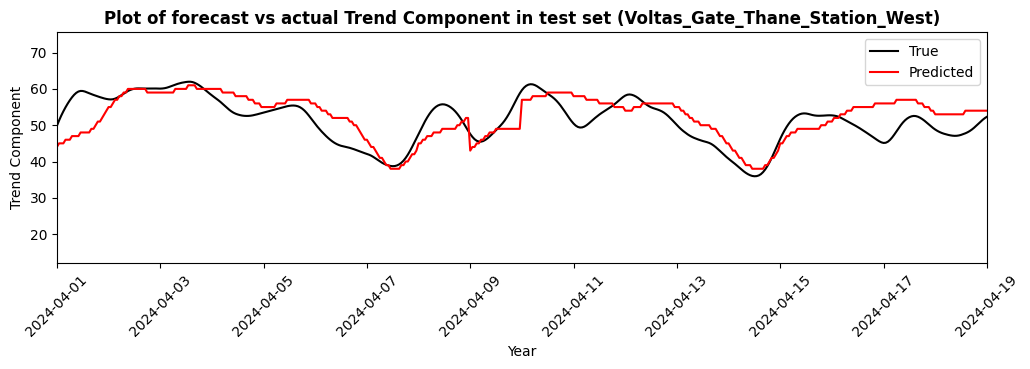

In [38]:
ind = X_test.index
xlabel = df.loc[ind,'Date_Time'].to_numpy()
plt.figure(figsize=(12, 3))
plt.plot(xlabel,y_test.to_numpy(),c='black',label='True')
plt.plot(xlabel,pred,label='Predicted',c='red')
plt.legend(loc=1)
plt.title(f'Plot of forecast vs actual Trend Component in test set ({sp})',fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Trend Component')
plt.xlim((pd.Timestamp(2024,4,1),pd.Timestamp(2024,4,19)))
plt.tick_params('x',labelrotation=45)

In [39]:
# Save the figure
plt.savefig(f'/kaggle/working/{sp}.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

In [40]:
best_params = study.best_params

In [41]:
best_params

{'lstm': 32, 'dropout': 0.8, 'lstm_2': 372, 'bs': 204}

# Append to Excel Function

In [42]:
def append_to_excel(file_path, data):
    try:
        # Load existing workbook or create a new one
        try:
            wb = load_workbook(file_path)
            ws = wb.active
        except FileNotFoundError:
            wb = Workbook()
            ws = wb.active
            ws.append(['sp',"All Years", 'lstm', 'dropout', 'lstm_2', 'bs', 'rmse', 'r2', 'mae', 'mape'])

        # Append data to the next available row
        ws.append(data)

        # Save the workbook
        wb.save(file_path)
        print("Data appended to Excel file successfully.")
    except Exception as e:
        print(f"Error: {e}")
lstm_value = best_params['lstm']
dropout_value = best_params['dropout']
lstm_2_value = best_params['lstm_2']
bs_value = best_params['bs']
            
# Append the data to the Excel file
data_to_append = [sp,"All Years", lstm_value, dropout_value, lstm_2_value, bs_value,rmse,rscore,mape,mae]
file_path = '/kaggle/working/Result.xlsx'
append_to_excel(file_path, data_to_append)

Data appended to Excel file successfully.


# 1st Jan 2022 to 1st June 2022

In [43]:
import pandas as pd
from feature_engine.timeseries.forecasting import LagFeatures

# Load the dataset
df = pd.read_csv('/kaggle/input/individual-seasonal-trend-residual-dataframes/df_trend.csv')

# Create lag features
lag_transformer = LagFeatures(variables=['Trend'], periods=[1, 2, 24, 24*7, 24*14, 24*21, 24*28])
df = lag_transformer.fit_transform(df)

# Drop rows with missing values after creating lag features
df = df.dropna()

# Create X (features) and y (target)
X = df.drop(columns=['Date_Time', 'Trend'])
y = df['Trend']

# X and y are now ready for modeling


In [44]:
df.head(3)

,Date_Time,Is_Holiday,Holiday_Type,OneHourSlot,Month,Year,Weekday,Trend,Trend_lag_1,Trend_lag_2,Trend_lag_24,Trend_lag_168,Trend_lag_336,Trend_lag_504,Trend_lag_672
672,2019-01-29 00:00:00,0,0,1,1,2019,1,72.053725,72.462210,72.980061,67.647424,76.775321,75.037219,77.471205,68.788995
673,2019-01-29 01:00:00,0,0,2,1,2019,1,71.797099,72.053725,72.462210,68.997820,76.527047,75.002987,77.376109,68.779800
674,2019-01-29 02:00:00,0,0,3,1,2019,1,71.691790,71.797099,72.053725,70.136641,76.414029,75.071696,77.321657,68.772500


In [45]:
X

,Is_Holiday,Holiday_Type,OneHourSlot,Month,Year,Weekday,Trend_lag_1,Trend_lag_2,Trend_lag_24,Trend_lag_168,Trend_lag_336,Trend_lag_504,Trend_lag_672
672,0,0,1,1,2019,1,72.462210,72.980061,67.647424,76.775321,75.037219,77.471205,68.788995
673,0,0,2,1,2019,1,72.053725,72.462210,68.997820,76.527047,75.002987,77.376109,68.779800
674,0,0,3,1,2019,1,71.797099,72.053725,70.136641,76.414029,75.071696,77.321657,68.772500
675,0,0,4,1,2019,1,71.691790,71.797099,71.122770,76.448529,75.233157,77.295879,68.766954
676,0,0,5,1,2019,1,71.706063,71.691790,72.015135,76.623370,75.467839,77.284999,68.762759
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46459,0,0,20,4,2024,4,56.460781,56.385058,49.808811,53.016968,54.026025,56.305112,55.388722
46460,0,0,21,4,2024,4,56.533830,56.460781,50.370035,52.498525,53.395408,56.720267,54.935932
46461,0,0,22,4,2024,4,56.606303,56.533830,50.933026,51.921324,52.676742,57.106281,54.425914
46462,0,0,23,4,2024,4,56.679462,56.606303,51.463233,51.308639,51.907232,57.417123,53.883858


In [46]:
y

672      72.053725
673      71.797099
674      71.691790
675      71.706063
676      71.790662
           ...    
46459    56.533830
46460    56.606303
46461    56.679462
46462    56.753581
46463    56.828206
Name: Trend, Length: 45792, dtype: float64

In [47]:
# Ensure Date_Time is converted to datetime format
df['Date_Time'] = pd.to_datetime(df['Date_Time'])

# Filter the DataFrame for the specified date range
temp = df[(df['Date_Time'] >= pd.Timestamp(2022, 1, 1)) & (df['Date_Time'] < pd.Timestamp(2022, 6, 1))]

# Check if the sum of 'Seasonal' is 0
if temp['Trend'].sum() == 0:
    # Split into train & test (95% for train and 5% for test)
    X_train = X.iloc[:int(np.round((0.95 * len(X)))), :]
    X_test = X.iloc[int(np.round((0.95 * len(X)))):, :]
    y_train = y[:int(np.round((0.95 * len(X))))]
    y_test = y[int(np.round((0.95 * len(X)))):]
else:
    # Split into train & test (80% for train and 20% for test)
    X_train = X.iloc[:int(np.round((0.8 * len(X)))), :]
    X_test = X.iloc[int(np.round((0.8 * len(X)))):, :]
    y_train = y[:int(np.round((0.8 * len(X))))]
    y_test = y[int(np.round((0.8 * len(X)))):]


In [48]:
# normalizing train set & reshape
sc_X = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = sc_X.fit_transform(X_train)
X_train_scaled_2 = np.reshape(X_train_scaled,(X_train_scaled.shape[0],X_train_scaled.shape[1],1))

sc_y = MinMaxScaler(feature_range = (0, 1))
y_train_scaled = sc_y.fit_transform(np.reshape(y_train,(len(y_train),1)))


# normalizing test set & reshape
X_test_scaled = sc_X.transform(X_test)
X_test_scaled_2 = np.reshape(X_test_scaled,(X_test_scaled.shape[0],X_test_scaled.shape[1],1))

In [49]:
model = tf.keras.models.load_model(f'/kaggle/working/Voltas_Gate_Thane_Station_West.keras')
pred_inverse = model.predict(X_test_scaled_2)
pred_2 = sc_y.inverse_transform(pred_inverse)
pred = np.floor(pred_2)

output = pd.DataFrame()
output = pd.concat([output,X_test],ignore_index=True)
output['Pred'] = pred
output['Actual'] = y_test.to_numpy()
output.to_csv(f'/kaggle/working/{sp}.csv')



287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# 20th april 2024 to 7th May 2024 11:00PM

In [50]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Load the data
check = pd.read_csv(f'/kaggle/working/input_file_1.csv')

# Create a date range and ensure it matches the length of the DataFrame
date_range = pd.date_range('2024-04-20 00:00', pd.Timestamp(2024, 5, 7, 23), freq='1H')
if len(date_range) != check.shape[0]:
    # Align the lengths by either truncating or extending the DataFrame
    if len(date_range) < check.shape[0]:
        check = check.iloc[:len(date_range)]
    else:
        additional_rows = pd.DataFrame({
           # 'Station_Pair': [sp] * (len(date_range) - check.shape[0]),
            'Date_Time': [pd.NaT] * (len(date_range) - check.shape[0]),
            'Trend': [0] * (len(date_range) - check.shape[0])
        })
        check = pd.concat([check, additional_rows], ignore_index=True)

# Assign the date range to the Date_Time column
check['Date_Time'] = date_range

# Define a custom function to create lag features
def create_lag_features(df, lag_vars, lags):
    for var in lag_vars:
        for lag in lags:
            df[f'{var}_lag_{lag}'] = df[var].shift(lag)
    return df

forecast_df = check.copy()
forecast_df['Trend'] = 0
ref_date = forecast_df['Date_Time'].iloc[0] - pd.Timedelta(days=400)
temp = df[(df['Date_Time'] >= ref_date)]
combined_df = pd.concat([temp, forecast_df], ignore_index=True)
index_start = combined_df[combined_df['Date_Time'] >= pd.Timestamp(2024, 4, 20)].index[0]
num_of_forecast = forecast_df.shape[0]

for index in range(num_of_forecast):
    temp = combined_df.loc[:index_start]

    # create lag features
    temp = create_lag_features(temp, lag_vars=['Trend'], lags=[1, 2, 24, 24*7, 24*14, 24*21, 24*28])
    temp.dropna(inplace=True)

    # create X
    X = temp.drop(columns=['Date_Time','Trend','OneHourSlot'])

    # normalizing test set & reshape
    sc_X = joblib.load(f'/kaggle/working/scaler_X_{sp}.joblib')
    X_scaled = sc_X.transform(X)
    X_scaled_2 = np.reshape(X_scaled, (X_scaled.shape[0], X_scaled.shape[1], 1))

    # predict on test set
    model = tf.keras.models.load_model(f'/kaggle/working/{sp}.keras')
    pred_inverse = model.predict(X_scaled_2[-1, :, :].T)
    sc_y = joblib.load(f'/kaggle/working/scaler_y_{sp}.joblib')
    pred_2 = sc_y.inverse_transform(pred_inverse)
    pred = np.floor(pred_2)
    pred = np.where(pred < 0, 0, pred)
    combined_df.loc[index_start, 'Trend'] = pred[0][0]
    index_start += 1

combined_df[combined_df['Date_Time'] >= pd.Timestamp(2024, 4, 20)].to_csv(f'/kaggle/working/forecast_{sp}.csv')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


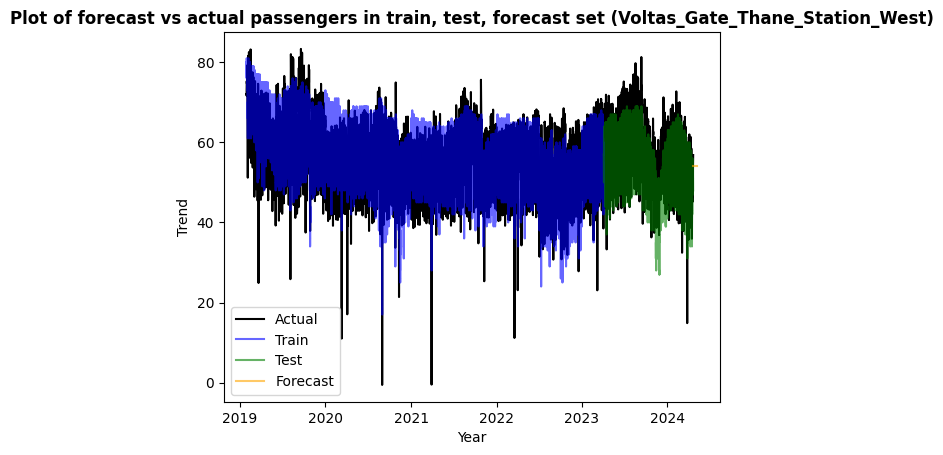

In [51]:
# Load predictions
file1 = pd.read_csv(f"/kaggle/working/Voltas_Gate_Thane_Station_West.csv")
pred = file1['Pred']
pred = np.where(pred < 0, 0, pred)

# Load the model for training predictions
model = tf.keras.models.load_model(f'/kaggle/working/{sp}.keras')
train_pred_inverse = model.predict(X_train_scaled_2)
train_pred_2 = sc_y.inverse_transform(train_pred_inverse)
train_pred = np.floor(train_pred_2)
train_pred = np.where(train_pred < 0, 0, train_pred)

# Load the forecast
forecast = pd.read_csv(f'/kaggle/working/forecast_{sp}.csv')
forecast['Date_Time'] = pd.date_range(pd.Timestamp(2024, 4, 20, 0, 0), pd.Timestamp(2024, 5, 7, 23, 0), freq='1H')

# Plot the results
plt.plot(df['Date_Time'].to_numpy(), df['Trend'].to_numpy(), c='black', label='Actual')
plt.plot(df.loc[X_train.index, 'Date_Time'].to_numpy(), train_pred, c='blue', label='Train', alpha=0.6)
plt.plot(df.loc[X_test.index, 'Date_Time'].to_numpy(), pred, c='green', label='Test', alpha=0.6)
plt.plot(forecast['Date_Time'].to_numpy(), forecast['Trend'], c='orange', label='Forecast', alpha=0.6)

plt.legend(loc=0)
plt.title(f'Plot of forecast vs actual passengers in train, test, forecast set ({sp})', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Trend')
plt.savefig(f'/kaggle/working/{sp}.tiff', format='tiff', dpi=300, bbox_inches='tight')